In [1]:
import sys
sys.path.append("/home/hwpc03/workspace/ma-yang/est_reproduction_likelihood_without")

In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import random
def DataProcessing(data):
        data = np.array(data)
        nsamples, nx, ny = data.shape
        if nx > 200:                                                # delete randomly datapoints
            index = random.sample(range(1,nx), nx-200)
            demo_data = np.delete(data, index, axis=1)
            demo_data_dim2 = demo_data.reshape((nsamples,-1))
            return demo_data, demo_data_dim2
        elif nx < 200:                                               # Interpolation
            demo_data = []
            for k in range(len(data)):
                values = np.reshape(data[k],-1)
                points = np.array([[i,j] for i in range(0, nx) for j in range(0, ny)])
                grid_x, grid_y = np.mgrid[0:nx-1:200j, 0:ny-1:4j]
                data_new = interpolate.griddata(points, values, (grid_x, grid_y), method='nearest')
                demo_data.append(data_new)
            demo_data = np.array(demo_data)
            demo_data_dim2 = demo_data.reshape((nsamples,-1))
            return demo_data, demo_data_dim2
        else:
            demo_data_dim2 = data.reshape((nsamples,-1))
            return data, demo_data_dim2

In [4]:
def separate_xdx(mydata_xdx):
    mydata_x = []
    mydata_dx = []
    if np.array(mydata_xdx).ndim == 3:
        for i in range(len(mydata_xdx)):
            temp_x = []
            temp_dx = []
            for j in range(len(mydata_xdx[i])):
                temp_x.append([mydata_xdx[i][j][0], mydata_xdx[i][j][1]])
                temp_dx.append([mydata_xdx[i][j][2], mydata_xdx[i][j][3]])
            temp_x1 = np.array(temp_x)
            temp_dx1 = np.array(temp_dx)
            mydata_x.append(temp_x1)
            mydata_dx.append(temp_dx1)
        return mydata_x, mydata_dx
    elif np.array(mydata_xdx).ndim == 2:
        temp_x = []
        temp_dx = []
        for i in range(len(mydata_xdx)):
            temp_x.append([mydata_xdx[i][0], mydata_xdx[i][1]])
            temp_dx.append([mydata_xdx[i][2], mydata_xdx[i][3]])
        return temp_x, temp_dx
    else:
        print("Error! The dimension of data is neither 2 or 3")

In [5]:
def create_hsmm_data(demo_pred):
    letter = demo_pred[0]
    files = ['demo%s'%letter, 'demo%s1'%letter, 'demo%s2'%letter, 'demo%s3'%letter, 'demo%s4'%letter, 'demo%s5'%letter, 'demo%s6'%letter, 'demo%s7'%letter, 'demo%s8'%letter, 'demo%s9'%letter]
    #files = ['demo%s'%letter, 'demo%s1'%letter, 'demo%s2'%letter, 'demo%s3'%letter, 'demo%s4'%letter]
    files.pop(0)

    train_data = np.load("./mydataset/demo%s.npy"%letter, allow_pickle=True)
    train_data = train_data.tolist()
    train_data_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(train_data['x'], train_data['dx'])]
    demo_data, _ = DataProcessing(train_data_xdx)
    for i in files:
        mydata1 = np.load("./mydataset/%s.npy"%i, allow_pickle=True)
        mydata1 = mydata1.tolist()
        mydata1_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(mydata1['x'], mydata1['dx'])]
        demo_data1, _ = DataProcessing(mydata1_xdx)
        demo_data = np.vstack((demo_data,demo_data1))
    return demo_data

In [6]:
def cal_errors(demos, preds):
    
    demos_data = np.array(demos).mean(axis=0)
    preds_data = np.array(preds).mean(axis=0)

    errors = pow(demos_data-preds_data, 2)
    errors = np.array([math.sqrt(pow(errors[0], 2) + pow(errors[1], 2))])
    return errors

In [7]:
def cal_distance(p1, p2):
    return math.sqrt(pow((p2[0] - p1[0]), 2) + pow((p2[1] - p1[1]), 2))

In [8]:
def cal_mse(demos, preds):
    
    mse = 0
#     if len(demos) > 1:
#         gt = np.array(demos).mean(axis = 0)
#     else:
#         gt = np.array(demos[0])

    # Find the point of intersection
    for i in range(len(demos)):
        distance = cal_distance(demos[i], preds[i])
        if distance != 0:
            intersection = i
            break
        else:
            continue

    # Normalization and calculate average mean squared errors
    if demos.shape[0] >= preds.shape[0]:
        nx, _ = demos.shape
        index = random.sample(range(intersection+1, nx), nx-preds.shape[0])
        print(index)
        demos_data = np.delete(demos, index, axis=0)
        for i in range(len(preds)):
            mse = mse + pow(preds[i]-demos_data[i], 2)
        
        mse = mse/len(preds)
#       mse = np.array([math.sqrt(pow(mse[0], 2) + pow(mse[1], 2)), math.sqrt(pow(mse[2], 2) + pow(mse[3], 2))])
        mse = np.array([math.sqrt(pow(mse[0], 2) + pow(mse[1], 2))])
        return mse
    elif demos.shape[0] < preds.shape[0]:
        nx, _ = preds.shape
        index = random.sample(range(intersection+1, nx), nx - demos.shape[0])
        print(index)
        preds_data = np.delete(preds, index, axis=0)
        for i in range(len(demos)):
            mse = mse + pow(preds[i]-demos[i], 2)
        
        mse = mse/len(preds)
#       mse = np.array([math.sqrt(pow(mse[0], 2) + pow(mse[1], 2)), math.sqrt(pow(mse[2], 2) + pow(mse[3], 2))])
        mse = np.array([math.sqrt(pow(mse[0], 2) + pow(mse[1], 2))])
        return mse

In [9]:
G H B P K

SyntaxError: invalid syntax (<ipython-input-9-7dd8b320e9e8>, line 1)

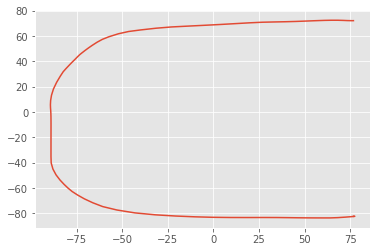

In [247]:
demos = np.loadtxt('./Evaluation/C_demonstration_1.txt')
plt.plot(demos[:,0], demos[:,1])
plt.show()

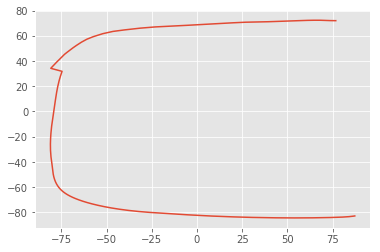

In [248]:
preds = np.load('./Evaluation/C_pred_1.npy', allow_pickle=True)
plt.plot(preds[:,0], preds[:,1])
plt.show()

In [249]:
demos.shape

(97, 2)

In [250]:
preds.shape

(152, 2)

In [251]:
for i in range(len(demos)):
    distance = cal_distance(demos[i], preds[i])
    if distance != 0:            
        intersection = i
        break
    else:
        continue

intersection

41

In [252]:
cal_distance(demos[intersection-1], preds[intersection-1])

0.0

In [253]:
cal_mse(demos, preds)

[125, 78, 131, 112, 45, 62, 135, 147, 140, 64, 96, 81, 93, 144, 87, 65, 44, 149, 72, 139, 85, 111, 89, 113, 101, 83, 90, 129, 107, 110, 46, 80, 52, 100, 86, 61, 108, 74, 73, 103, 106, 54, 99, 109, 60, 150, 145, 43, 94, 92, 68, 47, 63, 146, 142]


array([2922.78])

In [254]:
cal_errors(demos, preds)

array([194.53])

In [237]:
(2.66+689.61+48.24)/3

246.83666666666667

In [ ]:
data = np.load('./mydataset/myD_part_without.npy', allow_pickle=True)
data = data.tolist()
data = [np.hstack([_x, _dx]) for _x ,_dx in zip(data['x'], data['dx'])]
data, _ = separate_xdx(data)
data = np.array(data)

In [ ]:
data_part = []
for i in range(len(data)):
    if data[i][0] >= 60:
        data_part.append(data[i])

In [ ]:
plt.plot(data_part[:,0], data_part[:,1])
plt.show()

In [ ]:
cal_error(prediction, data_part)